In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

import torch.optim as optim

In [2]:
def loss_func(pred, y): return (pred-y)**2

In [55]:
def train(server_model, num_global_iters = 50, num_local_iters = 10, local_iter_thres = None,  lr = 0.1):
    # server_model = Model()
    client_models = [copy.deepcopy(server_model) for i in range(2)]

    memory = list()
    memory.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy()))
    memory_w = list()
    memory_w.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()))
    memory_b = list()
    memory_b.append(copy.deepcopy(server_model.scale.data.detach().cpu().numpy()))
    memory_loss = list()
    memory_c1 = list()
    memory_c1.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]**2 - server_model.scale.data.detach().cpu().numpy()**2))
    memory_c2 = list()
    memory_c2.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]**2 - server_model.scale.data.detach().cpu().numpy()**2))

    import pandas as pd
    if local_iter_thres == None: alg = "FedAvg"
    else: alg = "FedBug"
    def df_append(df, data): df.loc[len(df)] = data
    df = pd.DataFrame(columns=["w1", "w2", "v", "alg"])
    df_append(df,  [copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]), 
                    copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]),
                    copy.deepcopy(server_model.scale.data.detach().cpu().numpy()), alg])
    for epoch in range(num_global_iters):  
        
        client_models = [copy.deepcopy(server_model) for i in range(2)]
        optimizers = [optim.SGD(client_models[idx].parameters(), lr=lr) for idx in range(2)]
        
        for client_idx in range(2):
            model, optimizer = client_models[client_idx], optimizers[client_idx]
            X, Y = Data[client_idx]
            for local_iter in range(num_local_iters):
                
                if local_iter_thres == None: model.scale.requires_grad = True
                elif local_iter < local_iter_thres: model.scale.requires_grad = False
                else: model.scale.requires_grad = True
                                
                pred = model(X)
                loss = loss_func(pred, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if local_iter_thres == None: pass

                memory_c1.append(copy.deepcopy(model.weight.data.detach().cpu().numpy()[0]**2 - model.scale.data.detach().cpu().numpy()**2))
                memory_c2.append(copy.deepcopy(model.weight.data.detach().cpu().numpy()[1]**2 - model.scale.data.detach().cpu().numpy()**2))
                
        with torch.no_grad():
            server_model.weight.data.copy_(copy.deepcopy((client_models[0].weight.data + client_models[1].weight.data)/2))
            server_model.scale.data.copy_(copy.deepcopy((client_models[0].scale.data + client_models[1].scale.data)/2))
            memory.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy()))
            memory_w.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()))
            memory_b.append(copy.deepcopy(server_model.scale.data.detach().cpu().numpy()))
            memory_c1.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]**2 - server_model.scale.data.detach().cpu().numpy()**2))
            memory_c2.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]**2 - server_model.scale.data.detach().cpu().numpy()**2))
            df_append(df,  [copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[0]), 
                            copy.deepcopy(server_model.weight.data.detach().cpu().numpy()[1]),
                            copy.deepcopy(server_model.scale.data.detach().cpu().numpy()[0]), 
                            alg])
            loss = 0
            for client_idx in range(2):
                X, Y = Data[client_idx]
                pred = server_model(X)
                loss += loss_func(pred, Y).item() / 2
            memory_loss.append(loss)
    memory = np.array(memory)
    memory_loss = np.array(memory_loss)
    memory_w = np.array(memory_w)
    memory_b = np.array(memory_b)
    return memory, memory_loss, memory_w, memory_b, memory_c1, memory_c2, df

In [38]:
class Model(torch.nn.Module):
    def __init__(self, w = [0.6, 3], v = 0.5):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(w),  requires_grad=True)
        self.scale  = torch.nn.Parameter(torch.Tensor([v]),    requires_grad=True)
    def forward(self, x): return x @ self.weight * self.scale
Data = [[torch.Tensor([1, 0]), torch.Tensor([1])], 
        [torch.Tensor([0, 1]), torch.Tensor([1])]]

lr = 0.1
num_global_iters = 80
num_local_iters = 40
local_iter_thres = 10
# memory, memory_loss, memory_w, memory_b, memory_c1, memory_c2, df = train(index = 0, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = None,  lr = lr)
# memory2, memory_loss2, memory_w2, memory_b2, memory_c1_2, memory_c2_2, df2 = train(index = 0, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = local_iter_thres,  lr = lr)

In [90]:
def df_append(df, data): df.loc[len(df)] = data
df = pd.DataFrame(columns=["w1", "w2", "b", "loss_log_decay", "estimated_log_decay", "alg", "seed"])

alg = "FedAvg"
for i in range(50):
    
    if (i+1) % 5 == 0: print(i)
    np.random.seed(i)
    w = np.random.rand(2)*2
    v = np.random.rand(1)*2
    model = Model(w = w, v = v)
    memory, memory_loss, memory_w, memory_b, _, _, _ = train(model, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = None,  lr = lr)

    loss_log_decay = (np.log(memory_loss)[10:20] - np.log(memory_loss)[11:21]).mean()
    slope = -memory_b[-10:].mean()**2
    model_log_decay = np.sin(np.arctan(slope))**2
                           
    df_append(df,  [w[0], w[1], v[0], loss_log_decay, model_log_decay, alg, i])

4
9
14
19


/tmp/ipykernel_1627663/2229614549.py:14: RuntimeWarning:

divide by zero encountered in log



24
29
34
39
44
49


/tmp/ipykernel_1627663/2229614549.py:14: RuntimeWarning:

divide by zero encountered in log



<AxesSubplot: xlabel='loss_log_decay', ylabel='estimated_log_decay'>

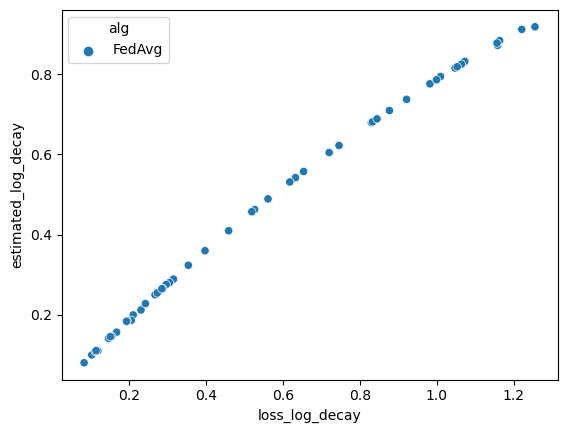

In [79]:
import seaborn as sns 
sns.scatterplot(data=df, x="loss_log_decay", y="estimated_log_decay", hue="alg")

In [91]:
def df_append(df, data): df.loc[len(df)] = data
df_BUG = pd.DataFrame(columns=["w1", "w2", "b", "loss_log_decay", "estimated_log_decay", "alg", "seed"])

for num_local_step_frozen in [1,2,4,10]:
    alg = "FedBUG_" + str(num_local_step_frozen)
    for i in range(50):
        if (i+1) % 5 == 0: print(i)
        np.random.seed(i)
        w = np.random.rand(2)*2
        v = np.random.rand(1)*2
        model = Model(w = w, v = v)
        memory, memory_loss, memory_w, memory_b, _, _, _ = train(model, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = num_local_step_frozen,  lr = lr)
        loss_log_decay = (np.log(memory_loss)[10:20] - np.log(memory_loss)[11:21]).mean()
        slope = -memory_b[-10:].mean()**2
        model_log_decay = np.sin(np.arctan(slope))**2                           
        df_append(df_BUG,  [w[0], w[1], v[0], loss_log_decay, model_log_decay, alg, i])

4
9
14
19


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



24
29
34


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



39


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



44
49
4


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



9
14


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



19


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



24


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



29
34
39
44


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



49


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



4
9
14
19
24


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



29
34
39
44


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



49
4


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



9
14


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



19
24


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



29
34


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



39


/tmp/ipykernel_1627663/3990918143.py:13: RuntimeWarning:

divide by zero encountered in log



44
49


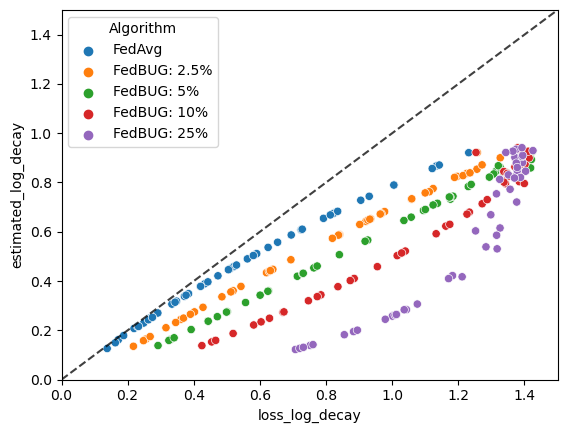

In [109]:
import seaborn as sns 
fig, axes = plt.subplots(1,1)
ax = axes
df_temp = copy.deepcopy(pd.concat([df, df_BUG]))
df_temp["Algorithm"] = df_temp["alg"]
replace_icon =   {"FedAvg": "FedAvg", 
                  "FedBUG_1":  "FedBUG: 2.5%", 
                  "FedBUG_2":  "FedBUG: 5%", 
                  "FedBUG_4":  "FedBUG: 10%", 
                  "FedBUG_10": "FedBUG: 25%", 
                 }
sk = list(replace_icon.keys())
df_temp = df_temp.set_index('Algorithm').loc[sk].reset_index()
df_temp = df_temp.replace({"Algorithm": replace_icon})

sns.scatterplot(data=df_temp, x="loss_log_decay", y="estimated_log_decay", hue="Algorithm", ax=ax)
maxv = 1.5
ax.plot([0, maxv], [0, maxv], "black", linestyle='--', alpha=0.75)
ax.set_ylim([0,maxv])
ax.set_xlim([0,maxv])

df_temp.to_csv("LogDecayDF_0424.csv")